# Get USTRUB rate from Binance exchange

In [1]:
import os
import pathlib 
import pandas as pd
from tqdm import tqdm
from datetime import datetime

from utils import append_df_to_excel

In [2]:
PATH_SRC = pathlib.Path()
PATH_DATA = pathlib.Path() / '../data'
PATH_REPORTS = pathlib.Path() / '../reports'

In [3]:
# DATES TO DOWNLOAD
START_DATE = '2022-04-15'
END_DATE = '2022-04-17'
dates = pd.date_range(start=START_DATE, end=END_DATE)
dates_str = list(pd.Series(dates).apply(lambda x: datetime.strftime(x, format='%Y-%m-%d')))

In [4]:
TICKER = 'USDTRUB'
print(f"https://data.binance.vision/data/spot/daily/klines/{TICKER}/1h/{TICKER}-1h-{dates_str[0]}.zip")

https://data.binance.vision/data/spot/daily/klines/USDTRUB/1h/USDTRUB-1h-2022-01-01.zip


In [5]:
PATH_DATA_BNB = PATH_DATA.absolute() / 'binance'
for date in tqdm(dates_str):
    link = f"https://data.binance.vision/data/spot/daily/klines/{TICKER}/1h/{TICKER}-1h-{date}.zip"
    
    os.system(f'wget "{link}" -P {PATH_DATA_BNB}')

  0%|          | 0/107 [00:00<?, ?it/s]--2022-04-18 12:54:55--  https://data.binance.vision/data/spot/daily/klines/USDTRUB/1h/USDTRUB-1h-2022-01-01.zip
Resolving data.binance.vision (data.binance.vision)... 13.227.246.108, 13.227.246.5, 13.227.246.6, ...
Connecting to data.binance.vision (data.binance.vision)|13.227.246.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [application/zip]
Saving to: ‘/home/ubuntu/fxcash/src/../data/binance/USDTRUB-1h-2022-01-01.zip.1’

     0K .                                                     100%  226M=0s

2022-04-18 12:54:56 (226 MB/s) - ‘/home/ubuntu/fxcash/src/../data/binance/USDTRUB-1h-2022-01-01.zip.1’ saved [1098/1098]

  1%|          | 1/107 [00:00<01:26,  1.22it/s]--2022-04-18 12:54:56--  https://data.binance.vision/data/spot/daily/klines/USDTRUB/1h/USDTRUB-1h-2022-01-02.zip
Resolving data.binance.vision (data.binance.vision)... 13.227.246.54, 13.227.246.6, 13.227.246.5, ...
Connecting to data.binance.

In [ ]:
FIRST_DATE = '2022-01-01' 
dates = pd.date_range(start=FIRST_DATE, end=END_DATE)

In [6]:
df = pd.DataFrame()
for date in tqdm(dates_str):
    df_i = pd.read_csv(PATH_DATA_BNB / f'{TICKER}-1h-{date}.zip', compression='zip',header=None)
    df = df.append(df_i)

100%|██████████| 107/107 [00:00<00:00, 164.29it/s]


In [7]:
df.columns = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore']
df['Open time'] = df['Open time'].apply(lambda x: datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))
df['Close time'] = df['Close time'].apply(lambda x: datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))

df['Open time'] = df['Open time'].astype('datetime64[ns]')
df['Close time'] = df['Close time'].astype('datetime64[ns]')

In [8]:
filename = f'{TICKER}_{START_DATE}_{END_DATE}.xlsx'
df.to_excel(PATH_REPORTS / filename)

<AxesSubplot:xlabel='Close time'>

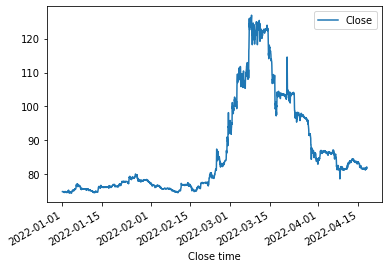

In [9]:
df[['Close time','Close']].set_index('Close time').plot()

In [10]:
# calculate price quantiles
quantiles = [0.1,0.25,0.5,0.75,0.9]

df_quantiles = pd.DataFrame()
df_usd_ask = df[['Close time','Close']].copy()
df_usd_ask_q = df_usd_ask.set_index('Close time')\
        .resample('1d').quantile(q=quantiles).reset_index()\
        .pivot(index='Close time',values='Close',columns='level_1')

df_usd_ask_q.columns = quantiles
df_usd_ask_q.columns = [f'q={x}_close' for x in quantiles]
df_quantiles = pd.concat([df_quantiles,df_usd_ask_q],axis=1)

In [11]:
# export quantiles to new sheet
append_df_to_excel(PATH_REPORTS / filename, df_quantiles, sheet_name='quantiles')